<a href="https://colab.research.google.com/github/emmelinetsen/Emerging_Technologies/blob/master/Dog_Breed_Classifier_and_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np
import pandas as pd

import time
from datetime import timedelta

import math
import os

import scipy.misc
from scipy.stats import itemfreq
from random import sample
import pickle

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Image manipulation
import PIL.Image
from IPython.display import display

# Open a Zip File
from zipfile import ZipFile
from io import BytesIO

In [3]:
from google.colab import drive
drive.mount('/content/drive')
!unzip -uq '/content/drive/My Drive/CMPE 278-98 - Emerging Technologies/Homework/dog-breed-id/train.zip'
!unzip -uq '/content/drive/My Drive/CMPE 278-98 - Emerging Technologies/Homework/dog-breed-id/test.zip'



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# We unzip the train and test zip file
train = ZipFile("/content/drive/My Drive/CMPE 278-98 - Emerging Technologies/Homework/dog-breed-id/train.zip", 'r')
test = ZipFile("/content/drive/My Drive/CMPE 278-98 - Emerging Technologies/Homework/dog-breed-id/test.zip", 'r')
# This line shows the 5 first image name of the train database
train.namelist()[0:5]
# This line shows the number of images in the train database, noted that we must remove the 1st value (column header)
len(train.namelist()[:]) - 1

10222

In [0]:
# This function help to create a pickle file gathering all the image from a zip folder
def DataBase_creator(archivezip, nwidth, nheight, save_name):
    # We choose the archive (zip file) + the new width and height for all the image which will be reshaped
    
    # Start-time used for printing time-usage below.
    start_time = time.time()
    
    # nwidth x nheight = number of features because images have nwidth x nheight pixels
    s = (len(archivezip.namelist()[:])-1, nwidth, nheight,3)
    allImage = np.zeros(s)
    for i in range(1,len(archivezip.namelist()[:])):
        filename = BytesIO(archivezip.read(archivezip.namelist()[i]))
        image = PIL.Image.open(filename) # open colour image
        image = image.resize((nwidth, nheight))
        image = np.array(image)
        image = np.clip(image/255.0, 0.0, 1.0) # 255 = max of the value of a pixel
        allImage[i-1]=image
    
    # we save the newly created data base
    pickle.dump(allImage, open( save_name + '.p', "wb" ) )
    
    # Ending time.
    end_time = time.time()
    # Difference between start and end-times.
    time_dif = end_time - start_time
    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [0]:
# Define the new image size applied for all images
# Create a pickle file for both the training and desting dataset
image_resize = 60
DataBase_creator(archivezip = train, nwidth = image_resize, 
                 nheight = image_resize , save_name = "/content/drive/My Drive/CMPE 278-98 - Emerging Technologies/Homework/pickle/train")
# DataBase_creator(archivezip = test, nwidth = image_resize, 
#                  nheight = image_resize , save_name = "/content/drive/My Drive/CMPE 278-98 - Emerging Technologies/Homework/pickle/test")

Time usage: 0:00:38


In [0]:
# load train pickle file
train = pickle.load( open( "/content/drive/My Drive/CMPE 278-98 - Emerging Technologies/Homework/pickle/train.p", "rb" ) )
train.shape

(10222, 60, 60, 3)

In [0]:
# load test pickle file
test = pickle.load( open( "/content/drive/My Drive/CMPE 278-98 - Emerging Technologies/Homework/pickle/test.p", "rb" ) )
test.shape

(10357, 60, 60, 3)

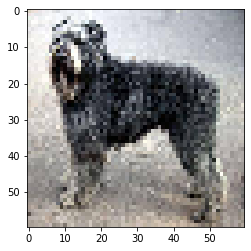

In [0]:
plt.imshow(test[100,:,:,:])

In [0]:
# reading in labels
path = "/content/drive/My Drive/CMPE 278-98 - Emerging Technologies/Homework/dog-breed-id/labels.csv"
labels = pd.read_csv(path)

In [0]:
# normalizing the images
image_resize = 60
nwidth = image_resize
nheight = image_resize

# nwidth x nheight = number of features because images are nwidth x nheight pixels
s = (len(labels['breed']), nwidth, nheight,3) 
allImage = np.zeros(s)

i = 0
for f, breed in labels.values:
    image = PIL.Image.open('../content/train/{}.jpg'.format(f))
    image = image.resize((nwidth, nheight))
    image = np.array(image)
    image = np.clip(image/255.0, 0.0, 1.0) # 255 = max of the value of a pixel
    i += 1
    allImage[i-1]=image

    train = allImage

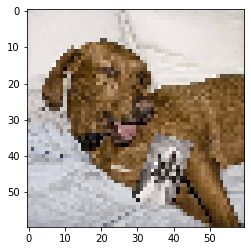

In [0]:

plt.imshow(train[100,:,:,:])
plt.show()

In [0]:
labels.sample(5)

id                    breed
9925  f97b9b8848683ab240cffeda2c855502              entlebucher
409   09d462e2ad4d8c51d1a8430577891d8a            irish_terrier
2497  3e2f226678909037ed26abc9c2289af9  black-and-tan_coonhound
8427  d3ab6b3d328b2cd91bed99aee99fa6ed                   kuvasz
7885  c552deb03796d5f050d9d2cfd1323d73        brabancon_griffon

In [0]:
labels["breed"]

0                     boston_bull
1                           dingo
2                        pekinese
3                        bluetick
4                golden_retriever
                   ...           
10217                      borzoi
10218              dandie_dinmont
10219                    airedale
10220          miniature_pinscher
10221    chesapeake_bay_retriever
Name: breed, Length: 10222, dtype: object

In [0]:
# Get the N most represented breeds
def main_breeds(labelsRaw, numBreeds , allBreeds='TRUE'):
    labels_freq_pd = itemfreq(labelsRaw["breed"])
    labels_freq_pd = labels_freq_pd[labels_freq_pd[:, 1].argsort()[::-1]]
    
    if allBreeds == 'FALSE':
        main_labels = labels_freq_pd[:,0][0:numBreeds]
    else: 
        main_labels = labels_freq_pd[:,0][:]
        
    labels_raw_np = labelsRaw["breed"].as_matrix()
    labels_raw_np = labels_raw_np.reshape(labels_raw_np.shape[0],1)
    labels_filtered_index = np.where(labels_raw_np == main_labels)
    return labels_filtered_index

In [0]:
breeds = 10
labels_filtered_index = main_breeds(labelsRaw = labels, numBreeds = breeds, allBreeds='FALSE')
labels_filtered = labels.iloc[labels_filtered_index[0],:]
train_filtered = train[labels_filtered_index[0],:,:,:]
print('- Number of images remaining after selecting the {0} main breeds : {1}'.format(breeds, labels_filtered_index[0].shape))
print('- The shape of train_filtered dataset is : {0}'.format(train_filtered.shape))

- Number of images remaining after selecting the 10 main breeds : (1141,)
- The shape of train_filtered dataset is : (1141, 60, 60, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.


In [0]:
# We select the labels from the N main breeds
labels = labels_filtered["breed"].as_matrix()
labels = labels.reshape(labels.shape[0],1) #labels.shape[0] looks faster than using len(labels)
labels.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


(1141, 1)

In [0]:
# Function to create one-hot labels
def matrix_Bin(labels):
    labels_bin=np.array([])

    labels_name, labels0 = np.unique(labels, return_inverse=True)
    labels0
    
    for _, i in enumerate(itemfreq(labels0)[:,0].astype(int)):
        labels_bin0 = np.where(labels0 == itemfreq(labels0)[:,0][i], 1., 0.)
        labels_bin0 = labels_bin0.reshape(1,labels_bin0.shape[0])

        if (labels_bin.shape[0] == 0):
            labels_bin = labels_bin0
        else:
            labels_bin = np.concatenate((labels_bin,labels_bin0 ),axis=0)

    print("Nber SubVariables {0}".format(itemfreq(labels0)[:,0].shape[0]))
    labels_bin = labels_bin.transpose()
    print("Shape : {0}".format(labels_bin.shape))
    
    return labels_name, labels_bin

In [0]:
labels_name, labels_bin = matrix_Bin(labels = labels)
labels_bin[0:9]

Nber SubVariables 10
Shape : (1141, 10)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  app.launch_new_instance()


array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

In [0]:
for breed in range(len(labels_name)):
   print('Breed {0} : {1}'.format(breed,labels_name[breed]))

Breed 0 : afghan_hound
Breed 1 : basenji
Breed 2 : bernese_mountain_dog
Breed 3 : entlebucher
Breed 4 : great_pyrenees
Breed 5 : maltese_dog
Breed 6 : pomeranian
Breed 7 : samoyed
Breed 8 : scottish_deerhound
Breed 9 : shih-tzu


In [0]:
labels_cls = np.argmax(labels_bin, axis=1)
labels[0:9]

array([['basenji'],
       ['scottish_deerhound'],
       ['maltese_dog'],
       ['shih-tzu'],
       ['samoyed'],
       ['scottish_deerhound'],
       ['entlebucher'],
       ['entlebucher'],
       ['maltese_dog']], dtype=object)

In [0]:
num_validation = 0.30
X_train, X_validation, y_train, y_validation = train_test_split(train_filtered, labels_bin, test_size=num_validation, random_state=6)

In [0]:
# split original data to train and test sets
def train_test_creation(x, data, toPred): 
  indices = sample(range(data.shape[0]),int(x * data.shape[0])) 
  indices = np.sort(indices, axis=None) 
  
  index = np.arange(data.shape[0]) 
  reverse_index = np.delete(index, indices,0)
  
  train_toUse = data[indices]
  train_toPred = toPred[indices]
  test_toUse = data[reverse_index]
  test_toPred = toPred[reverse_index]

  return train_toUse, train_toPred, test_toUse, test_toPred

df_train_toUse, df_train_toPred, df_test_toUse, df_test_toPred = train_test_creation(0.7, train_filtered, labels_bin)

df_validation_toPred_cls = np.argmax(y_validation, axis=1)
df_validation_toPred_cls[0:9]

array([6, 4, 7, 2, 6, 9, 1, 1, 8])

In [0]:
# The 100 pixels in each dimension.
img_size = image_resize

# Number of colour channels for the images: 3
num_channels = 3

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Image Shape
img_shape = (img_size, img_size, num_channels)

# Number of classes : 5 breeds
num_classes = breeds

def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
    #outputs random value from a truncated normal distribution

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))
    #outputs the constant value 0.05

In [0]:
# definte convolutional layer
def conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True,
                   use_dropout=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)
    
    if use_dropout:
        layer = tf.nn.dropout(layer,keep_prob_conv)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

In [0]:
# definte flatten layer
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

In [0]:
# define fully connected layer
def fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True,
                 use_dropout=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)
    
    if use_dropout:
        layer = tf.nn.dropout(layer,keep_prob_fc)
        
    return layer

In [0]:
# setting up placeholder tensor
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, num_channels], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels]) #-1 put everything as 1 array
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, axis=1)
keep_prob_fc=tf.placeholder(tf.float32)
keep_prob_conv=tf.placeholder(tf.float32)

In [0]:
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 32         # There are 32 of these filters.


# Convolutional Layer 2.
filter_size2 = 4          # Convolution filters are 4 x 4 pixels.
num_filters2 = 64      # There are 64 of these filters.


# Convolutional Layer 3.
filter_size3 = 3          # Convolution filters are 3 x 3 pixels.
num_filters3 = 128      # There are 128 of these filters.


# Fully-connected layer.
fc_size = 500 

layer_conv1, weights_conv1 = \
    conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True,
                   use_dropout=False)
    
layer_conv2, weights_conv2 = \
    conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True,
                   use_dropout=False)
    
layer_conv3, weights_conv3 = \
    conv_layer(input=layer_conv2,
                   num_input_channels=num_filters2,
                   filter_size=filter_size3,
                   num_filters=num_filters3,
                   use_pooling=True,
                   use_dropout=True)

layer_flat, num_features = flatten_layer(layer_conv3)

#Train
layer_fc1 = fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True,
                         use_dropout=True)

layer_fc2 = fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False,
                         use_dropout=False)

#Prediction
y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred, axis=1)

In [0]:
# defining loss function to train the model
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2, labels=y_true)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [0]:
# train the network
session = tf.Session()
def init_variables():
   session.run(tf.global_variables_initializer())

In [0]:
# creates a batch from a dataset
# the batch is used to train the model

batch_size = 50

#function next_batch
def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[i] for i in idx]
    labels_shuffle = [labels[i] for i in idx]


    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [0]:
def optimize(num_iterations, X):
    global total_iterations
    
    start_time = time.time()
    
    #array to plot
    losses = {'train':[], 'validation':[]}
    
    for i in range(num_iterations):
            total_iterations += 1
            # Get a batch of training examples.
            # x_batch now holds a batch of images and
            # y_true_batch are the true labels for those images.
            x_batch, y_true_batch = next_batch(batch_size, X_train, y_train)


            # Put the batch into a dict with the proper names
            # for placeholder variables in the TensorFlow graph.
            feed_dict_train = {x: x_batch,
                               y_true: y_true_batch,
                               keep_prob_conv : 0.3,
                               keep_prob_fc : 0.4}
            feed_dict_validation = {x: X_validation,
                               y_true: y_validation,
                               keep_prob_conv : 1,
                               keep_prob_fc : 1}
            
            # Run the optimizer using this batch of training data.
            # TensorFlow assigns the variables in feed_dict_train
            # to the placeholder variables and then runs the optimizer.
            session.run(optimizer, feed_dict=feed_dict_train)
            
            acc_train = session.run(accuracy, feed_dict=feed_dict_train)
            acc_validation = session.run(accuracy, feed_dict=feed_dict_validation)
            losses['train'].append(acc_train)
            losses['validation'].append(acc_validation)
            
            # Print status every X iterations.
            if (total_iterations % X == 0) or (i ==(num_iterations -1)):
            # Calculate the accuracy on the training-set.
                                
                msg = "Iteration: {0:>6}, Training Accuracy: {1:>6.1%}, Validation Accuracy: {2:>6.1%}"
                print(msg.format(total_iterations, acc_train, acc_validation))
                
    
    # Ending time.
    end_time = time.time()


    # Difference between start and end-times.
    time_dif = end_time - start_time


    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))
    
    plt.plot(losses['train'], label='Training loss')
    plt.plot(losses['validation'], label='Validation loss')
    plt.legend()
    _ = plt.ylim()

Iteration:    250, Training Accuracy:  24.0%, Validation Accuracy:  21.9%
Iteration:    500, Training Accuracy:  30.0%, Validation Accuracy:  28.6%
Iteration:    750, Training Accuracy:  54.0%, Validation Accuracy:  31.2%
Iteration:   1000, Training Accuracy:  56.0%, Validation Accuracy:  34.1%
Iteration:   1250, Training Accuracy:  56.0%, Validation Accuracy:  34.4%
Iteration:   1500, Training Accuracy:  68.0%, Validation Accuracy:  35.3%
Iteration:   1750, Training Accuracy:  60.0%, Validation Accuracy:  34.7%
Iteration:   2000, Training Accuracy:  74.0%, Validation Accuracy:  33.5%
Iteration:   2250, Training Accuracy:  90.0%, Validation Accuracy:  35.0%
Iteration:   2500, Training Accuracy:  90.0%, Validation Accuracy:  34.7%
Iteration:   2750, Training Accuracy:  84.0%, Validation Accuracy:  35.3%
Iteration:   3000, Training Accuracy:  92.0%, Validation Accuracy:  34.1%
Iteration:   3250, Training Accuracy:  88.0%, Validation Accuracy:  33.2%
Iteration:   3500, Training Accuracy: 

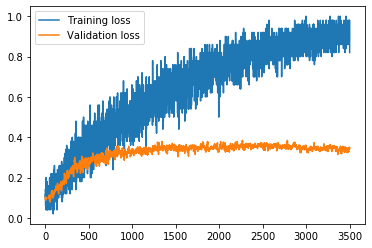

In [0]:
init_variables()
total_iterations = 0
optimize(num_iterations=3500, X=250)

The above model does not perform very well. It tends to overfit and isn't very good. The best validation accuracy was only 34.4%

### Transfer Learning


Using VGG16 model's convolutional base to extract features from the dog images to run through the classifier

In [0]:
%matplotlib inline
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir, makedirs
from os.path import join, exists, expanduser
from tqdm import tqdm
from sklearn.metrics import log_loss, accuracy_score
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications import xception
from keras.applications import inception_v3
from keras.applications.vgg16 import preprocess_input, decode_predictions
from sklearn.linear_model import LogisticRegression

In [5]:
# reading in labels
path = "/content/drive/My Drive/CMPE 278-98 - Emerging Technologies/Homework/dog-breed-id/labels.csv"
labels = pd.read_csv(path)

# selecting only the top 10 classes of breeds
selected_breed_list = list(labels.groupby('breed').count().sort_values(by='id', ascending=False).head(10).index)
labels = labels[labels['breed'].isin(selected_breed_list)]

labels['id'] = labels['id'] + '.jpg'
labels.head()

id               breed
8   003df8b8a8b05244b1d920bb6cf451f9.jpg             basenji
9   0042188c895a2f14ef64a918ed9c7b64.jpg  scottish_deerhound
12  00693b8bc2470375cc744a6391d397ec.jpg         maltese_dog
57  0162b3e0144fb1d1ab82fbff3ace9938.jpg            shih-tzu
70  01b36cb1b80ab8c3a7d2b7128ad21bdc.jpg             samoyed

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
BATCH = 32
imagegen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=.1,
    width_shift_range=.1,
    height_shift_range=.1,
    rotation_range=30,
    horizontal_flip=True,
    validation_split=.2
    )
train_generator = imagegen.flow_from_dataframe(
    dataframe=labels,
    directory='/content/train',
    x_col='id',
    y_col='breed',
    class_mode='categorical',
    target_size=(224,224),
    subset='training',
    batch_size=BATCH)
val_generator = imagegen.flow_from_dataframe(
    dataframe=labels,
    directory='/content/train',
    x_col='id',
    y_col='breed',
    class_mode='categorical',
    target_size=(224,224),
    subset='validation',
    batch_size=BATCH)

Found 913 validated image filenames belonging to 10 classes.
Found 228 validated image filenames belonging to 10 classes.


In [7]:
import keras
import keras.layers as layers
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, BatchNormalization, Activation, GlobalAveragePooling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.applications import VGG16, ResNet50V2



base = ResNet50V2(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))
base.trainable=False


def build_model():
  model = keras.Sequential()

  model.add(base)
  model.add(GlobalAveragePooling2D())
  model.add(layers.Dense(units=512, activation='relu'))
  model.add(layers.Dense(units=10, activation = 'softmax'))
  
  return model

In [8]:
model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 24,619,018
Trainable params: 1,054,218
Non-trainable params: 23,564,800
_________________________________________________________________


In [9]:
from keras.optimizers import Adam

opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [10]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("classifier.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')


hist = model.fit_generator(steps_per_epoch=len(train_generator),
                           generator=train_generator, validation_data= val_generator, 
                           validation_steps=len(val_generator),epochs=10, 
                           callbacks=[checkpoint,early], shuffle=True)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
29/29 [==============================] - 24s 831ms/step - loss: 0.9714 - acc: 0.6559 - val_loss: 0.5202 - val_acc: 0.8684

Epoch 00001: val_acc improved from -inf to 0.86842, saving model to classifier.h5
Epoch 2/10
29/29 [==============================] - 15s 512ms/step - loss: 0.3954 - acc: 0.8583 - val_loss: 0.5555 - val_acc: 0.8596

Epoch 00002: val_acc did not improve from 0.86842
Epoch 3/10
29/29 [==============================] - 17s 603ms/step - loss: 0.3204 - acc: 0.8794 - val_loss: 0.5461 - val_acc: 0.8860

Epoch 00003: val_acc improved from 0.86842 to 0.88596, saving model to classifier.h5
Epoch 4/10
29/29 [==============================] - 18s 613ms/step - loss: 0.2703 - acc: 0.9119 - val_loss: 0.6014 - val_acc: 0.8553

Epoch 00004: val_acc did not improve from 0.88596
Epoch 5/10
29/29 [==============================] - 18s 611ms/step - loss: 0.2509 - acc: 0.9225 - val

In [27]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("classifier.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')


hist = model.fit_generator(steps_per_epoch=len(train_generator),
                           generator=train_generator, validation_data= val_generator, 
                           validation_steps=len(val_generator),epochs=15, 
                           callbacks=[checkpoint,early], shuffle=True)

Epoch 1/15
29/29 [==============================] - 19s 650ms/step - loss: 0.1255 - acc: 0.9549 - val_loss: 0.5668 - val_acc: 0.8772

Epoch 00001: val_acc improved from -inf to 0.87719, saving model to classifier.h5
Epoch 2/15
29/29 [==============================] - 18s 615ms/step - loss: 0.1598 - acc: 0.9367 - val_loss: 0.6167 - val_acc: 0.8816

Epoch 00002: val_acc improved from 0.87719 to 0.88158, saving model to classifier.h5
Epoch 3/15
29/29 [==============================] - 18s 610ms/step - loss: 0.1482 - acc: 0.9463 - val_loss: 0.7392 - val_acc: 0.8772

Epoch 00003: val_acc did not improve from 0.88158
Epoch 4/15
29/29 [==============================] - 18s 615ms/step - loss: 0.1482 - acc: 0.9495 - val_loss: 0.3755 - val_acc: 0.9079

Epoch 00004: val_acc improved from 0.88158 to 0.90789, saving model to classifier.h5
Epoch 5/15
29/29 [==============================] - 18s 609ms/step - loss: 0.0976 - acc: 0.9646 - val_loss: 0.6907 - val_acc: 0.8553

Epoch 00005: val_acc did not

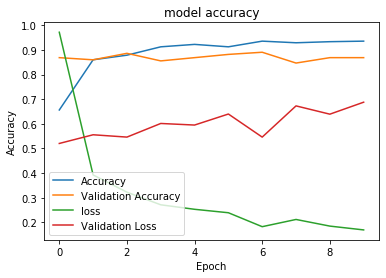

In [11]:
import matplotlib.pyplot as plt
plt.plot(hist.history["acc"])
plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [36]:
selected_breed_list

['scottish_deerhound',
 'maltese_dog',
 'afghan_hound',
 'entlebucher',
 'bernese_mountain_dog',
 'shih-tzu',
 'great_pyrenees',
 'pomeranian',
 'basenji',
 'samoyed']

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:350: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


[[1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 6.9996452e-27 4.1430195e-30]]


'scottish_deerhound'

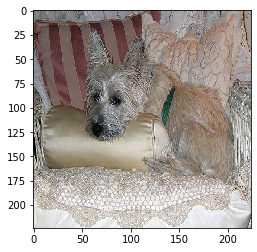

In [0]:
from keras.preprocessing import image
img = image.load_img("/content/test/0a0f82d4557f70718efa26f8a8a7773f.jpg",target_size=(224,224))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)

from keras.models import load_model
saved_model = load_model("classifier.h5")
output = saved_model.predict(img)
print(output)
selected_breed_list[np.argmax(output)]


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:350: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


'great_pyrenees'

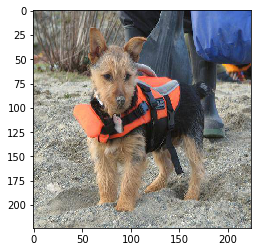

In [39]:
from keras.preprocessing import image
img = image.load_img("/content/test/0c278ed448bfd1b7f06854a5a9be7128.jpg",target_size=(224,224))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)

from keras.models import load_model
saved_model = load_model("/content/classifier.h5")
output = model.predict(img)
print(output)
selected_breed_list[np.argmax(output)]


In [22]:
selected_breed_list

['scottish_deerhound',
 'maltese_dog',
 'afghan_hound',
 'entlebucher',
 'bernese_mountain_dog',
 'shih-tzu',
 'great_pyrenees',
 'pomeranian',
 'basenji',
 'samoyed']

### Visualization

In [72]:
# We preprocess the image into a 4D tensor
from keras.preprocessing import image
import numpy as np

img = image.load_img('/content/test/0c278ed448bfd1b7f06854a5a9be7128.jpg', target_size=(224, 224))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor /= 255.

# Its shape is (1, 150, 150, 3)
print(img_tensor.shape)

(1, 224, 224, 3)


In [0]:
def build_model():
  model = Sequential()
  model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


  model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

  model.add(Flatten())
  model.add(Dense(units=4096))
  model.add(BatchNormalization())
  model.add(Activation("relu"))
  model.add(Dense(units=4096))
  model.add(BatchNormalization())
  model.add(Activation("relu"))

  model.add(Dense(units=10, activation="softmax"))

  return model

In [80]:
model = build_model()
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 56, 56, 256)       295168    
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 56, 56, 256)       590080    
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 28, 28, 256)      

In [44]:
model.layers[:2]


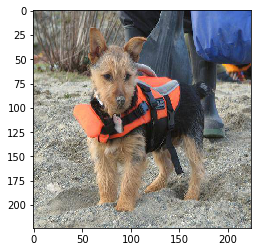

In [63]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

In [0]:
from keras import models

# Extracts the outputs of the top 3 layers:
layer_outputs = [layer.output for layer in model.layers[:9]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)


In [0]:
# This will return a list of 5 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(img_tensor)

In [84]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 224, 224, 64)


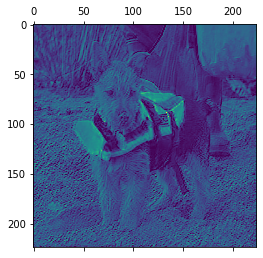

In [85]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')
plt.show()

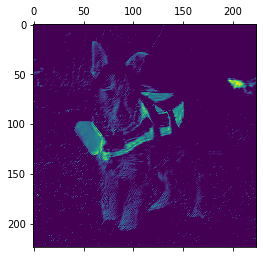

In [86]:
plt.matshow(first_layer_activation[0, :, :, 30], cmap='viridis')
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


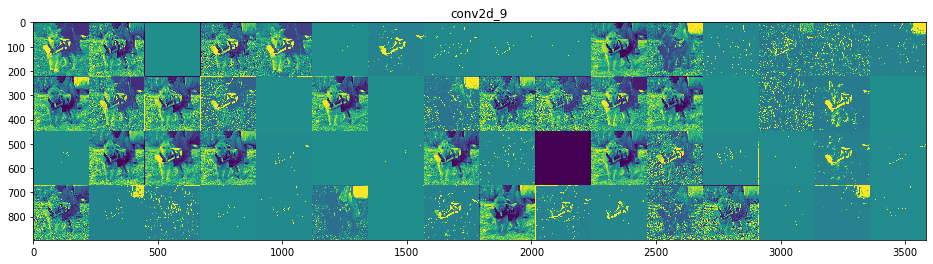

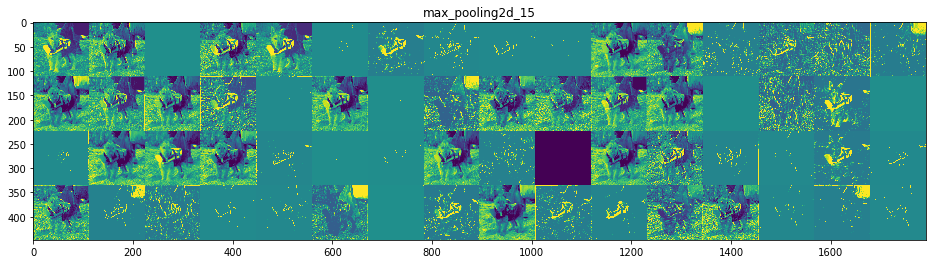

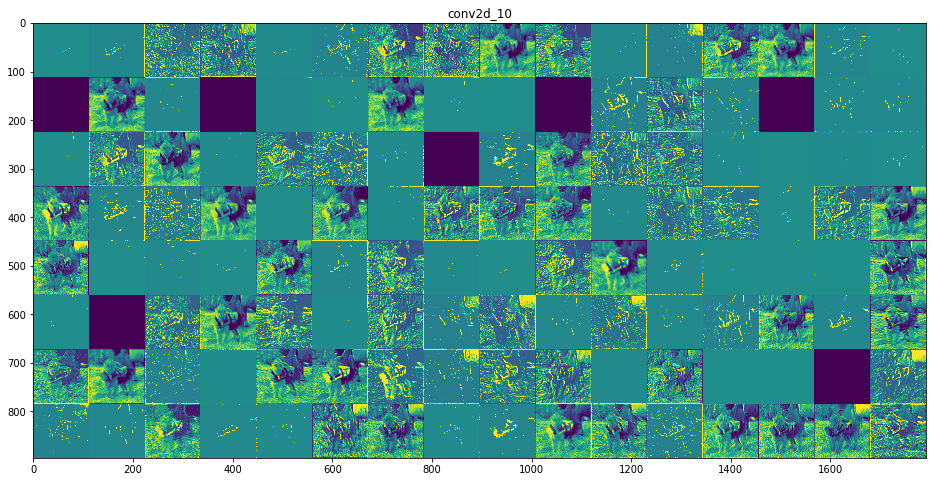

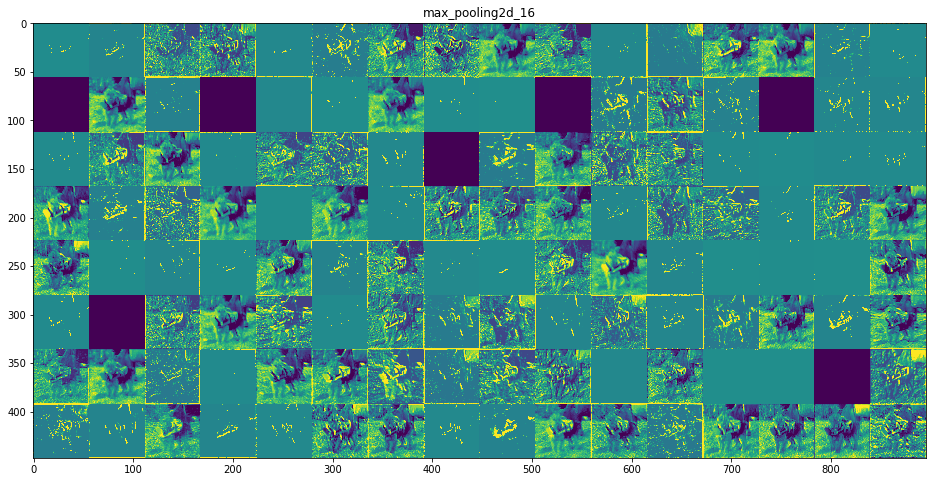

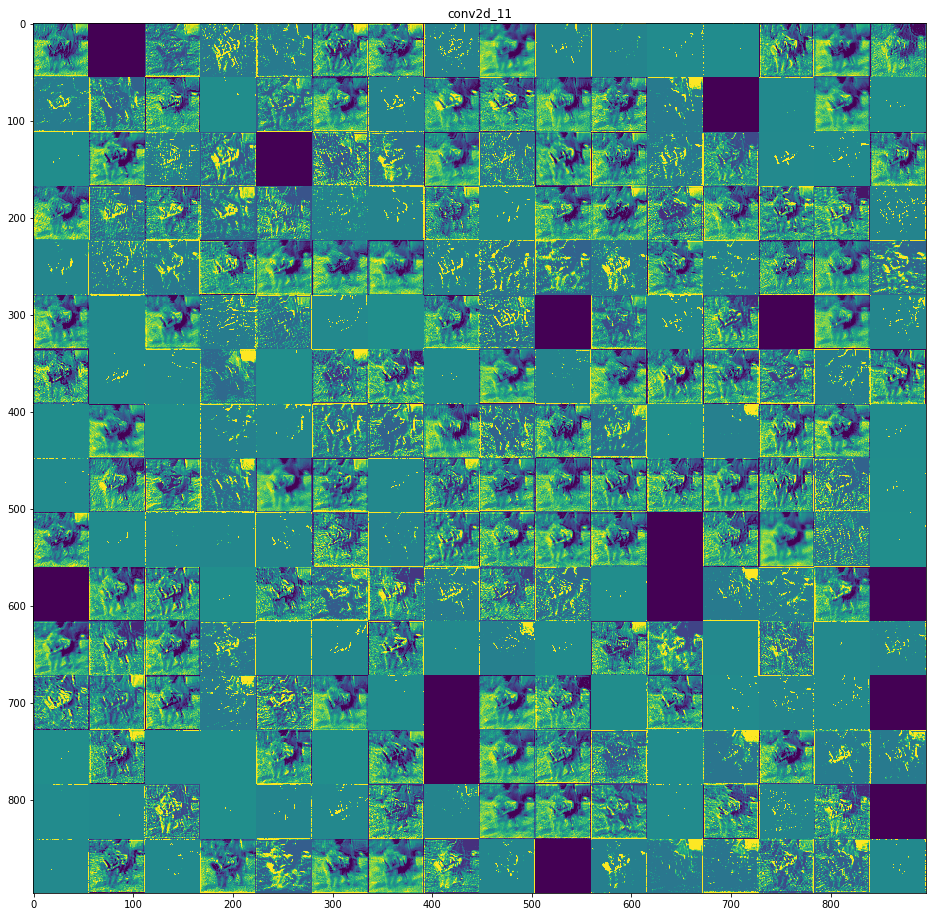

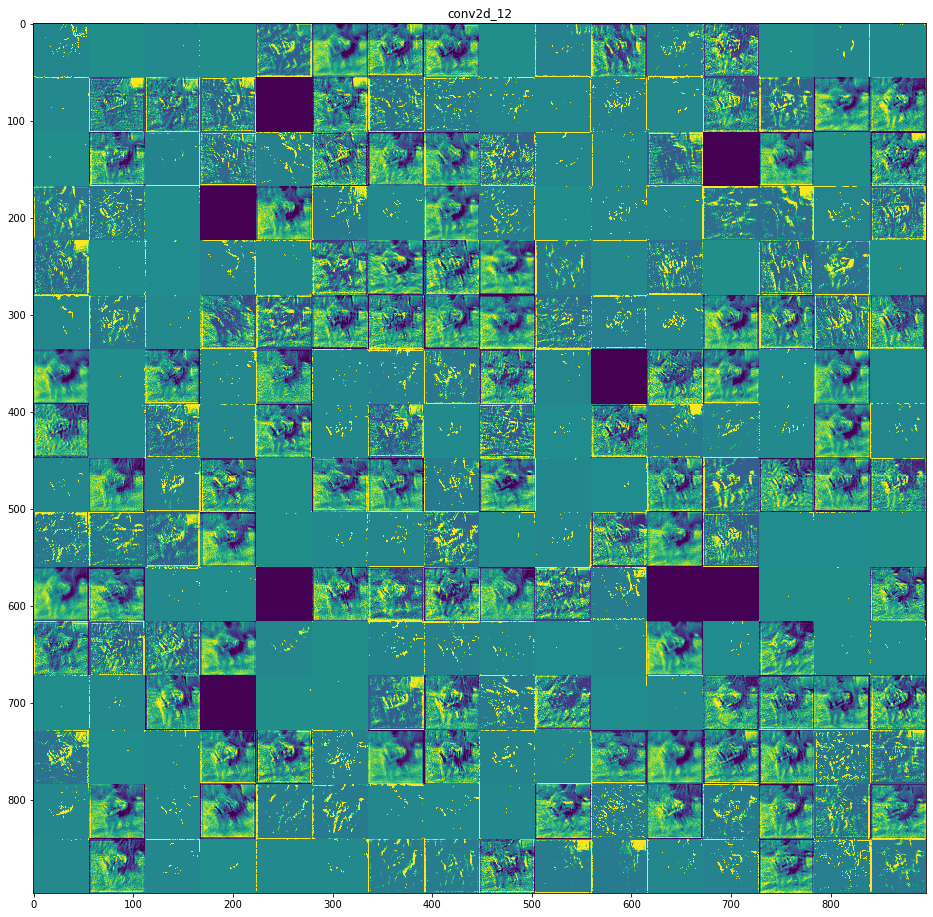

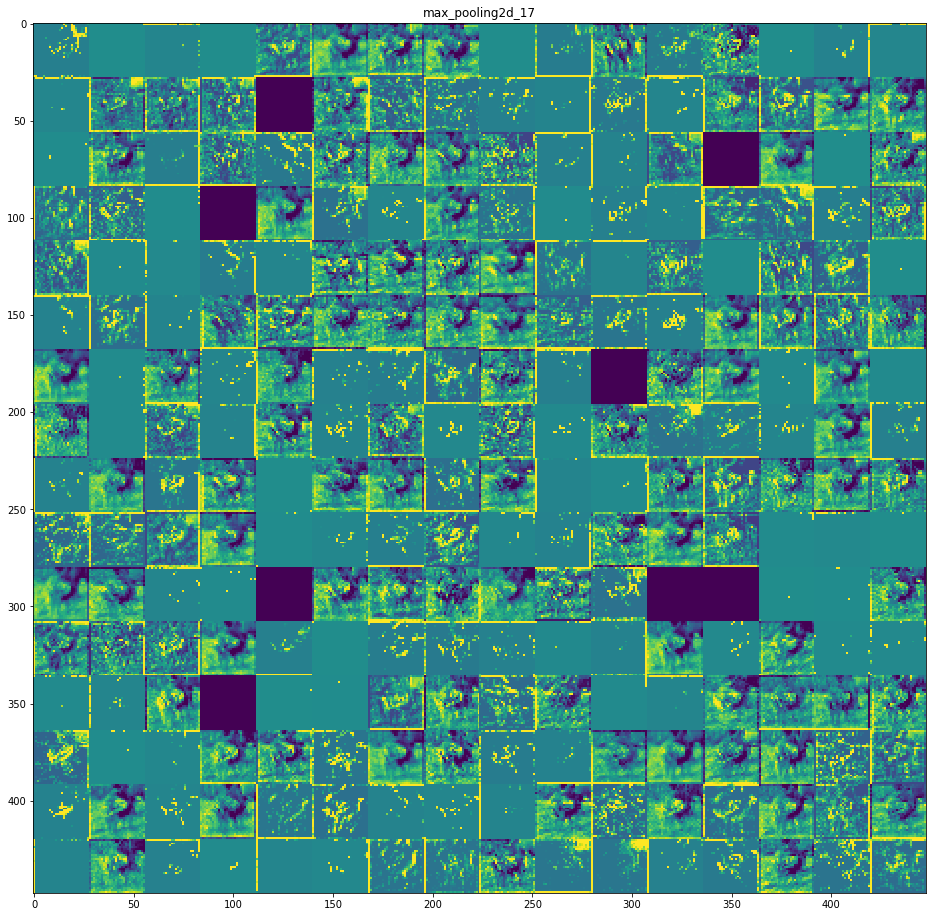

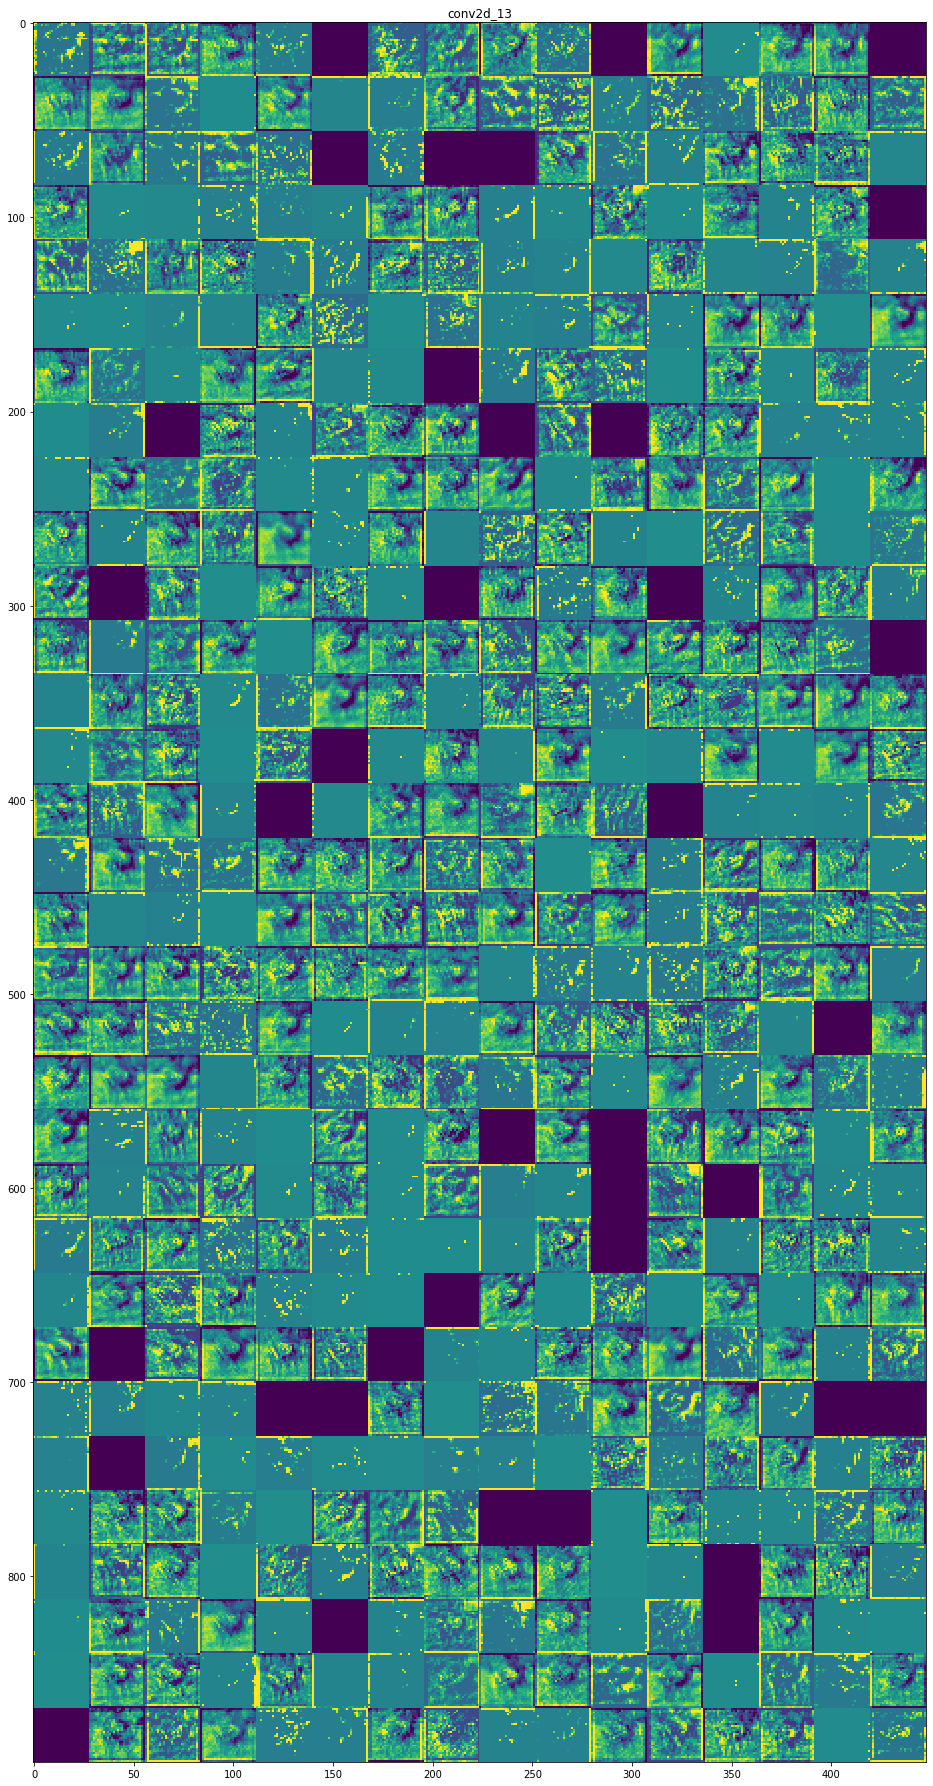

In [87]:
import keras

# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()